# Zillow 2017 Report

Glady Barrios 
July, 27, 2022

## Project Goal

Goals for this project are to proved insights on the housing market in three area codes in southern California and to find the key drivers of property value for single family properties in 2017.



## Project Description

The main goal for this project is to use Machine learning models to help predict the home values using a home report of 2017 and using single family Residendials.With this project we will wrangle raw zillow data, explore the data, run statistical test, and end it off with predicting home values with our machine learning models. This prediction is important for not only zillow as a company but our future customers and familys who are looking for afordable housing in California. At the end of the presentation We will discover the best model for prediction of housing cost out of all the models tested. 

### Mini - Data dictionary

- bathroomcnt- this displays a bathroom count of 1-6

- bedroomcnt- this displays a bedroom count of 1-6	

- calculatedfinishedsquarefeet- The Number of sqarefeet per property

- taxvaluedollarcnt- The cost of the property  

- yearbuilt- Year the property was built 

- fips- this is the area code the property resides 

- County- The name of the county the property is in, three properties include Los Angeles County, Ventura County, Orange 


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing


from wrangle import wrangle_zillow
from prepare import train_validate_test_split, scale_data

from scipy import stats
from math import sqrt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

### Wrangle the Zillow data 

In [2]:
df = wrangle_zillow()

df.head(3)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,transactiondate,County
0,2.0,3,1048,380118,1952,6037,2017-01-13,Los Angeles County
1,2.0,3,1324,518089,1963,6037,2017-01-13,Los Angeles County
3,3.0,4,2519,106406,1965,6037,2017-01-13,Los Angeles County


Quick recap on the Zillow  wrangling
- when hadeling nulls, I did drop them which left me with more than enough data (99%) to continue my project 
- removed outliers such as Properties with 6+ bathrooms and bedrooms as well as 0 bathrooms and bedrooms
- Created a new column that shows the counties the property is in 

In [3]:
#we will now explore using the train, this will be used as well to predict on the 
train, validate, test = train_validate_test_split(df)

train.shape, validate.shape, test.shape

((27773, 8), (11903, 8), (9920, 8))

In [4]:
#Scaled data will help our models have a well balaced data to make better and more accurate predictions 
train_s, valid_s, test_s = scale_data(train, validate, test)

In [5]:
train_s.head(3)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,transactiondate,County
51278,0.0,0.4,0.108761,119668,1960,6111,2017-08-31,Ventura County
30633,0.2,0.6,0.308020,919553,1922,6037,2017-06-13,Los Angeles County
1069,0.3,0.4,0.176600,390871,1964,6059,2017-01-06,Orange County


____________________

# Exploring the Data 

Lets take a quick look at the data 

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(12,6))
sns.countplot(train['bathroomcnt'], ax=ax[0])
sns.countplot(train['bedroomcnt'], ax=ax[1])
fig.show()

Takeaways- many of the properties in our dataset have 2 bathrooms and the majority of the properties have 3 bedrooms

In [ ]:
sns.histplot(data=train, x= 'calculatedfinishedsquarefeet')

Takeaways- many of the properties are within 1,000 sqft and 3,000 sqft 

In [ ]:
sns.histplot(data=train, x= 'County')

Recap
- many of the properties in this train dataset are in Los Angeles County 
- many of the properties in our dataset have 2 bathrooms and the majority of the properties have 3 bedrooms
- many of the properties are within 1,000 sqft and 3,000 sqft 

##  Question 1- Is there a relationship with the number of bathrroms a property has and the county the property is in ?

In [ ]:
sns.countplot(x= 'bathroomcnt', hue = "County", data=train)
fig.show()

In [ ]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
# Setup a crosstab of bathroom count and County  
#This is the best statistical test becasue we are looking at two categorical variables 
observed = pd.crosstab(train.bathroomcnt, train.County)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")
p

Main takeaways- 
- There is a realtionship between the number of bathrooms and the area it is in
- Looks like many of the 2 bathrooms properties are located in LA county and orange county 
- Overall we can see from the graph that the majority f properties no matter the county have 2 bathrooms 

Remember from earlier majority of all countly propertys seem to have 2 bathrooms.

## Question 2- Does a property with a certain number of bathrooms cause an increase in property value?

In [ ]:
sns.barplot(x= 'bathroomcnt', y='taxvaluedollarcnt', data=train, palette="rocket")

## Question 3- Does a property with a certain number of bedrooms cause an increase in property value?


$H_o$- There is no linear correlation between bedroom count and property value 

$H_a$ - there is a linear realtionship between bedrrom and property value

In [ ]:
sns.barplot(x= 'bedroomcnt', y='taxvaluedollarcnt', data=train, palette="rocket")

In [ ]:
corr, p = stats.pearsonr(train.bedroomcnt, train.taxvaluedollarcnt)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    


Takeaways so far
- For the number of bedrooms there is a reationship with the value of the property as we can see on the graph above the more bedroom the higher the value of the property.

 ## Question 4- Is there a relationship with the number of bedrooms a property has to the county it is in ?

In [ ]:
 sns.countplot(x= 'bedroomcnt', hue = "County", data=train)

$H_o$ : Bedroom count and county are independent 

$H_a$ : There is a relationship between bathroom count and County 

In [ ]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
# Setup a crosstab of observed bedroom count and county
#This is the best statistical test becasue we are looking at two categorical variables 
observed = pd.crosstab(train.bedroomcnt, train.County)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")
    


Main takeaways
- from the looks of or our graph and our statisticl test there is a relationhsip  with the number of bedrooms and the county the property is located 
- for all the counties the many of the properties have 2 to 4 bedrooms, majority being 3 or 4 bedrooms


### Exploration Summary 

- Overall we can see from the graph that the majority of properties no matter the county have 2 bathrooms 
- For the number of bedrooms there is a reationship with the value of the property as we can see on the graph above the more bedroom the higher the value of the property.
- For all the counties the many of the properties have 2 to 4 bedrooms, majority being 3 or 4 bedrooms
- From our bedroom and bathroom exploration there seems to be a much larger correlation with property value with bathrooms rather than the number of bedrooms 


-------------------------

# Lets Start Modeling!

### establishing the baseline 

We are now going to use scaled data from earlier 
- I used linear scaling to create normality in the data
- Unscaled data can inpact some of our models negatively and give us inaccurate predictions 

In [6]:
# I decided to use these three factors
X_train = train_s[['bathroomcnt', 'calculatedfinishedsquarefeet']]
y_train = train[['taxvaluedollarcnt']]
X_validate = valid_s[['bathroomcnt', 'calculatedfinishedsquarefeet']]
y_validate = validate[['taxvaluedollarcnt']]
X_test = test_s[['bathroomcnt', 'calculatedfinishedsquarefeet']]
y_test = test[['taxvaluedollarcnt']]

In [7]:
baseline = train.taxvaluedollarcnt.mean()

train['baseline'] = baseline
validate['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train.taxvaluedollarcnt, train.baseline))
valid_rmse = sqrt(mean_squared_error(validate.taxvaluedollarcnt, validate.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(valid_rmse))

Train baseline RMSE: 298182.01227437635.
Validation baseline RMSE: 302522.8095888484.


Our end goal for modeling is to find a model that has the lowest RMSE (Root Mean Squared Error) and beat that baseline!
 - RMSE is an evaluation metric, that will measure "how good a model is" and measure how well a model predicts the target variable, which is the value of a property
 - In our models, RMSE is already in dollar value, perfect for comparison
    

-----------------------

I went ahead and did four ML models

- OLS- (Ordiary Least Squares)

- LassoLars 

- GLM- (Generalized Linear Model)

- Polyniomial Model- This model had the lowest RMSE

## OLS model 

Our goal is to find a model with the least ammount of error when using our multiple variables 

In [8]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['tax_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.tax_pred_lm)**(1/2)

# predict validate
y_validate['tax_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.tax_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  250715.05044390244 
Validation/Out-of-Sample:  252479.33407779186


--------------------

## LassoLars

In [9]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['tax_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.tax_pred_lars)**(1/2)

# predict validate
y_validate['tax_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  250715.1113067819 
Validation/Out-of-Sample:  252479.86932253823


-------------------

## GLM Model 

In [10]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['tax_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.tax_pred_glm)**(1/2)

# predict validate
y_validate['tax_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.tax_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  254269.73751587025 
Validation/Out-of-Sample:  257590.14434118292


---------------------------------------

## Polynomial Model

In [11]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [12]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['tax_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.tax_pred_lm2)**(1/2)

# predict validate
y_validate['tax_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.tax_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  250081.39204286167 
Validation/Out-of-Sample:  252119.60223339367


-----------------------

### Lets take a look

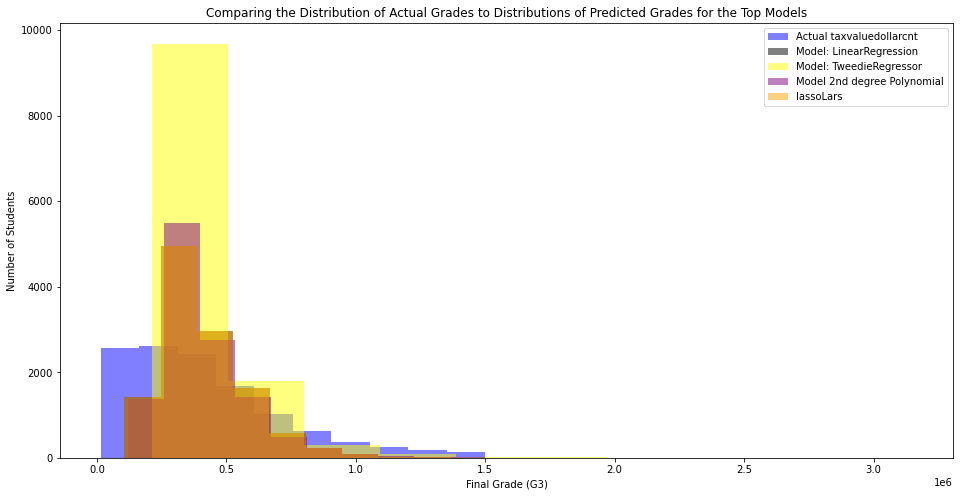

In [13]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual taxvaluedollarcnt")
plt.hist(y_validate.tax_pred_lm, color='black', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_pred_lm2, color='purple', alpha=.5, label="Model 2nd degree Polynomial")
plt.hist(y_validate.tax_pred_lars, color='orange', alpha=.5, label="lassoLars")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()

###  Lets train on test 

In [14]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.tax_pred_lm2)**(1/2)

print("RMSE for 2nd Degree Polynomial Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)


RMSE for 2nd Degree Polynomial Model using LinearRegression
Out-of-Sample Performance:  256779.34542650112


In [ ]:
def calculate_mse(y_predicted):
    return mean_squared_error(y_train.taxvaluedollarcnt, y_predicted)

y_train.apply(calculate_mse).sort_values()

In [15]:
y_train.head()

,taxvaluedollarcnt,tax_pred_lm,tax_pred_lars,tax_pred_glm,tax_pred_lm2
51278,119668,219275.902554,219507.291054,262074.815163,240973.583988
30633,919553,510356.373916,510308.889580,459169.716997,496893.912532
1069,390871,357097.176475,357109.819654,357428.971401,343350.488027
5125,58361,254439.223658,254647.127072,278970.162970,275461.746915
15166,396326,312163.109509,312247.995664,322882.704340,304300.172492


###   Lets Recap!

When modeling we want to find a model that has the lowest RMSE aka the lowest ammount of errors
- The best model for this was the 2nd degree polynimoal mode with the lowest root mean squared error 
- This is the best model out all four models used at predicting a property value (AKA taxvaluedollarcount) 

# Conclusion 

In conclusion what we did today was 
- we wrangled the data
- explored the data with our bedrroms and bathrooms - found that there is more of a realtionship with home value with the number of bathrooms
- The best model to predict home value is 2nd degree polynomial model 

### Recomendations 

- My recomendation is to use 2nd degree polynomial when working with the data to predict home value
- Looking at other features that could increase home value such as shools, parks, libaries, churches, diffrent establishments.
- looking at the diffrent social econimic issues in the area tha couls efect home prices 

## Next Steps

- My next stps are to try diffrent models and maybe try diffrent features I was unable to try.
- maybe use the same models but try diffrent  features of the models such as powers, alphas, etc.. 
